# Processing Images

Here we enhance the images (training and testing) to improve the image quality.

The processing steps:
1. Reads the input image
2. Converts from BGR to RGB
3. Crop black border around retina:
    - ODIR images have large black margins → waste resolution.
4. Center the retina
    - More consistent images
5. Mask outside retina :
    - Removes corner glare
    - Removes camera borders
    - Keeps retinal signal intact
6. CLAHE to enhance local contrast
7. Saves the processed 

```python
    def preprocess_image(self, img):
        img = self.crop_black_border(img)
        img = self.center_retina(img)
        img = self.mask_outside_retina(img)
        img = self.apply_clahe(img)
        return img
```


Define display images function

In [8]:
import os
import cv2
from matplotlib import pyplot as plt
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10):
    plt.suptitle(title, fontsize=20)
    img_count = len(image_filenames)
    plt.figure(figsize=(15, 15))
    for i in range(1, img_count+1):
        plt.subplot(5, col_count, i)
        image_path=image_filenames[i-1]
        image_name=os.path.basename(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_name}")
        plt.axis(False)
    plt.show();

Define our image processor class

In [9]:
import cv2
import numpy as np
from pathlib import Path

class ODIRImageProcessor:
    """Simple processor for ODIR retinal images"""
    
    def __init__(self, output_size=512):
        self.output_size = output_size
    
    def process(self, input_path, output_path=None, skip_if_exist=True, threshold=10):
        """
        Process a single ODIR image
        
        Args:
            input_path: Path to input image
            output_path: Optional path to save result. If None, returns image array
        
        Returns:
            Processed image as numpy array
        """
        if skip_if_exist and output_path is not None:
            if os.path.exists(output_path):
                print(f"Skip as processed image existed: {output_path}")
                return

        # Read image
        img = cv2.imread(str(input_path))
        if img is None:
            raise ValueError(f"Cannot read image: {input_path}")
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Call Preprocess script
        img = self.preprocess_image(img,threshold=threshold)

        # Convert back to BGR for saving/display
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        # Save if output path is provided
        if output_path:
            cv2.imwrite(str(output_path), img_bgr)
            print(f"Saved processed image to: {output_path}")
        
       # return img_bgr
    def preprocess_image(self, img, threshold=10):
        img = self.crop_black_border(img, thresh=threshold)
        img = self.crop_fundus_circle(img)
        img = self.center_retina(img)
        img = self.mask_outside_retina(img)
        img = self.apply_clahe(img)
        return img

    def gamma_correction(self, img, gamma=0.9):
        img_float = img.astype(np.float32) / 255.0
        # Gamma correction
        img_gamma = np.power(img_float, gamma)
        # Convert back to 0–255 for saving
        img_result = (img_gamma * 255).astype(np.uint8)
        return img_result

    def resize(self, img):
        return cv2.resize(img, 
                          (self.output_size, self.output_size), 
                          interpolation=cv2.INTER_CUBIC)

    def crop_black_border(self, img, thresh=10):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # mask of non-black pixels
        mask = gray > thresh

        if not np.any(mask):
            return img  # fallback safety

        coords = np.column_stack(np.where(mask))
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        return img[y_min:y_max+1, x_min:x_max+1]

    def crop_fundus_circle(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, th = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)

        x, y, w, h = cv2.boundingRect(cnt)
        return img[y:y+h, x:x+w]

    def mask_outside_retina(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, th = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)

        mask = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        return cv2.bitwise_and(img, mask)

    def center_retina(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, th = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)

        x, y, w, h = cv2.boundingRect(cnt)
        crop = img[y:y+h, x:x+w]

        # pad to square
        h, w = crop.shape[:2]
        size = max(h, w)
        padded = np.zeros((size, size, 3), dtype=crop.dtype)

        y0 = (size - h) // 2
        x0 = (size - w) // 2
        padded[y0:y0+h, x0:x0+w] = crop

        return padded


    def apply_clahe(self, image):
        """
            Apply CLAHE contrast enhancement
            This is a bit controversial as some suggested it, while others said it make it worse
        """
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l_channel, a, b = cv2.split(lab)
        
        # Apply CLAHE to L-channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel = clahe.apply(l_channel)
        
        # Merge back
        lab = cv2.merge([l_channel, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    def process_folder(self, input_folder, output_folder, skip_if_exist, extension=".jpg"):
        """
        Process all images in a folder
        """
        input_folder = Path(input_folder)
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)
        
        image_files = list(input_folder.glob(f"*{extension}"))
        print(f"Found {len(image_files)} images to process")
        
        for img_path in image_files:
            output_path = output_folder / img_path.name
            try:
                self.process(img_path, output_path, skip_if_exist=skip_if_exist)
            except Exception as e:
                print(f"Error processing {img_path.name}: {e}")

# Initialize processor
#processor = ODIRImageProcessor(output_size=512)

# Process single image
#processor.process(
#    input_path="path/to/your/image.jpg",
#    output_path="path/to/save/processed_image.jpg"
#)

# OR process entire folder
# processor.process_folder(
#     input_folder="path/to/images",
#     output_folder="path/to/processed_images"
# )

Test on 1 image and then dispaly and compare

Saved processed image to: /tmp/clahe.jpg


<Figure size 640x480 with 0 Axes>

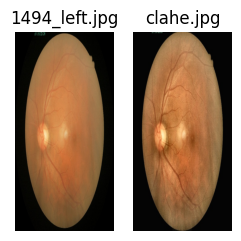

In [10]:
import os
input_folder="ODIR-2019/preprocessed_images"
output_folder="ODIR-2019/processed_512c_images"
input_image=f"{input_folder}/1494_left.jpg"
os.makedirs(output_folder, exist_ok=True)
processor = ODIRImageProcessor(output_size=512)
processor.process(input_image, "/tmp/clahe.jpg", skip_if_exist=False)
images=[input_image, "/tmp/clahe.jpg"]
display_images(images);

We can see from above that our image processing  work without changing much of the image as long as gamma is low

Let us be safe and conservative.
We shall do the minimal and safe preprocessing for all the images with  gamma 0.9 and low threshold=10

In [11]:
processor.process_folder(input_folder, output_folder, skip_if_exist=True) # default gamma=0.9, threshold=10

Found 6392 images to process
Saved processed image to: ODIR-2019/processed_512c_images/2750_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/2417_left.jpg
Saved processed image to: ODIR-2019/processed_512c_images/4304_left.jpg
Saved processed image to: ODIR-2019/processed_512c_images/4631_left.jpg
Saved processed image to: ODIR-2019/processed_512c_images/2817_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/2346_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/3363_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/3009_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/2902_left.jpg
Saved processed image to: ODIR-2019/processed_512c_images/1196_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/4238_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/2065_right.jpg
Saved processed image to: ODIR-2019/processed_512c_images/3163_right.jpg
Saved processed image to: 

In [12]:
import os
import cv2
import pandas as pd
import math

def sample_images(train_data, sample_count):
    return train_data.groupby('label_detail').apply(lambda x: x.sample(sample_count)).reset_index(drop=True)

def view_random_images(samples, data_set_img_folder, title):
    images_path = list(samples['filename'])
    labels = list(samples['label_detail'])
    samples_count = len(samples)
    class_count=8
    num_rows=math.ceil(samples_count/class_count)
    plt.figure(figsize=(class_count*2, num_rows*2))
    plt.suptitle(title, fontsize=14)
    for i in range(1, samples_count+1):
        plt.subplot(num_rows,class_count , i)
        image_path=os.path.join(data_set_img_folder, images_path[i-1])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{labels[i-1]}-{images_path[i-1].split('/')[-1]}", fontsize=8)
        plt.axis(False);
    plt.show()
result_datapath="ODIR-2019/results"
train_df = pd.read_csv(os.path.join(result_datapath, '01_eda_train_df.csv'))
samples = sample_images(train_df, 2)
samples
#view_random_images(train_df, input_folder, "Before Processing")
#view_random_images(train_df, output_folder, "After Processing")

/tmp/ipykernel_47148/2444207367.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return train_data.groupby('label_detail').apply(lambda x: x.sample(sample_count)).reset_index(drop=True)


,filename,label_detail,keywords,label
0,153_right.jpg,ageing,dry age-related macular degeneration,A
1,1856_right.jpg,ageing,wet age-related macular degeneration,A
2,949_right.jpg,cataract,cataract,C
3,2127_left.jpg,cataract,cataract,C
4,699_right.jpg,diabetes,moderate non proliferative retinopathy epireti...,D
5,4395_left.jpg,diabetes,mild nonproliferative retinopathy,D
6,1230_left.jpg,glaucoma,glaucoma diabetic retinopathy,G
7,1221_left.jpg,glaucoma,glaucoma macular epiretinal membrane,G
8,4592_right.jpg,hypertension,hypertensive retinopathy,H
9,861_left.jpg,hypertension,hypertensive retinopathy,H


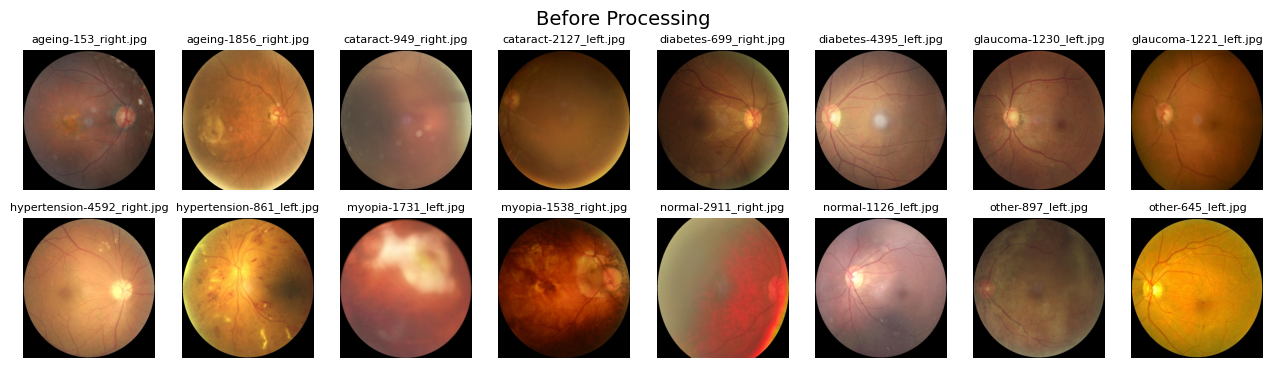

In [13]:
view_random_images(samples, input_folder, "Before Processing")

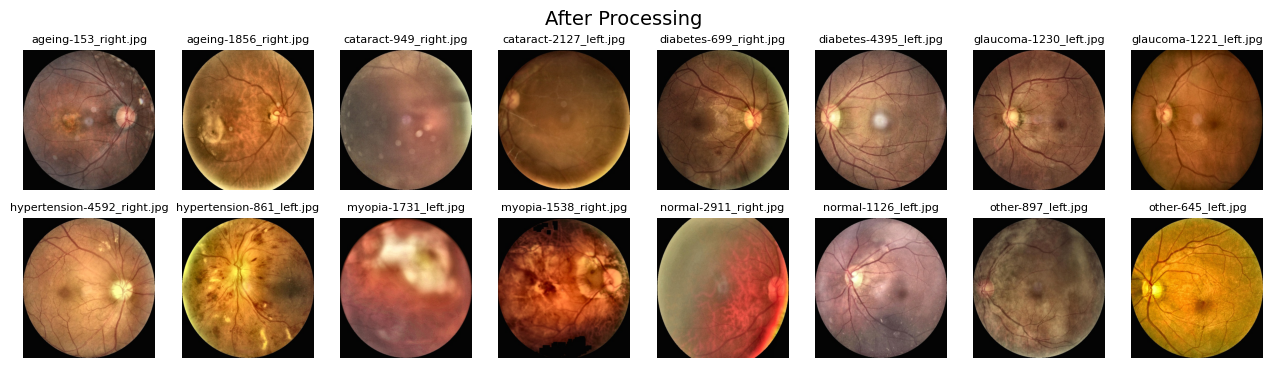

In [14]:
view_random_images(samples, output_folder, "After Processing")